In [10]:
from tensorflow.keras.optimizers import Adam
from Models.Loss import NLL
from Models.Distributions import *
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from Utils.Dataset import getData
from Utils.transform import cutOut, Normalize
from tensorflow.keras.callbacks import *
from Models.Utils import *
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import os
import cv2 as cv
import numpy as np

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)



Num GPUs: 1


In [11]:
def simpleUnet(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    

    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64

    
    layer = Conv2D(2, (1, 1), activation="linear")(up01)  # 1 x 64x64

    layer_1 = Flatten()(layer[:,:,:,:1])
    layer_2 = Flatten()(layer[:,:,:,1:2])
    layer_1 = Dropout(0.5)(layer_1)
    layer_2 = Dropout(0.5)(layer_2)
    layer_1 = Dense(64*64,activation="sigmoid")(layer_1)
    layer_2 = Dense(64*64,activation="relu")(layer_2)
    layer_1 = tf.keras.layers.Reshape((64,64,1))(layer_1)
    layer_2 = tf.keras.layers.Reshape((64,64,1))(layer_2)
    input_dist= tf.concat([layer_1,layer_2],axis=-1)

    output_dist = tfp.layers.DistributionLambda(name="DistributionLayer",
                                                make_distribution_fn=lambda t: tfp.distributions.Independent(
                                                tfd.Mixture(
                                                cat=tfd.Categorical(tf.stack([1-t[...,:1], t[...,:1]],axis=-1)),
                                                components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
                                                tfd.Poisson(rate=tf.math.softplus(t[...,1:2]))])
                                                ,name="ZeroInflated",reinterpreted_batch_ndims=0 ))
    
    
    output = output_dist(input_dist)
    model = Model(inputs=inputs, outputs=output)
    return model

In [12]:
BATCH_SIZE = 50
DIMENSION = (64,64)
CHANNELS = 5
MODELPATH = "./Models_weights"
MODELNAME = "zeroinflated_Poisson"



def getModel():
    modelpath = MODELPATH
    modelname = MODELNAME

    
    if not os.path.exists(modelpath):
            os.mkdir(modelpath)

    modelpath = os.path.join(modelpath,modelname)

    if not os.path.exists(modelpath):
        os.mkdir(modelpath)

    
    input_shape = (*DIMENSION,CHANNELS)

    model = simpleUnet(
                input_shape=input_shape
                )

    x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(BATCH_SIZE,
                         DIMENSION,CHANNELS,
                         timeToPred=10,
                         x_transform=x_transform)
    
    def NLL(y_true, y_hat):
        return -y_hat.log_prob(y_true)

    #neg_log_likelihood = lambda x, rv_x: tf.math.reduce_mean(-rv_x.log_prob(x))
    
    model.compile(loss=NLL,
                  optimizer=Adam( lr= 1e-3 ))
    model.summary()
    modelpath_h5 = os.path.join(modelpath,
                            modelname+'-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5')

    checkpoint = ModelCheckpoint(modelpath_h5,
                                 verbose=0,
                                 monitor='val_loss',
                                 save_best_only=True,
                                 mode='auto')

    return model,checkpoint,modelpath,train,test

In [ ]:

modelpath = MODELPATH
modelname = MODELNAME

model,checkpoint,modelpath,train,test = getModel()



history_path = os.path.join(modelpath,modelname+"_history")
laststate = getBestState(modelpath,history_path)
test.setWiggle_off()
#train.setWiggle_off()


if laststate:
    epoch = laststate["epoch"]
    model.load_weights(laststate["modelpath"])


    loss = model.evaluate(x=test, verbose=2)
    print("Restored model, loss: {:5.5f}".format(loss))

    history = model.fit(train,
                        validation_data = test,
                        shuffle         = True,
                        epochs          = 100+epoch,
                        initial_epoch   = epoch,
                        batch_size      = BATCH_SIZE,
                        callbacks       = checkpoint)

    history = mergeHist(laststate["history"],history.history)

else:
    history = model.fit(train,
                        validation_data = test,
                        shuffle         = True,
                        epochs          = 100,
                        batch_size      = BATCH_SIZE,
                        callbacks       = checkpoint)

    history = history.history





saveHistory(history_path,history)
plotHistory(history,history_path,title="ZeroInflatedPoisson NLL-loss")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 10)   460         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 64, 10)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 10)   0           activation_4[0][0]               
____________________________________________________________________________________________

4506/4506 [==============================] - 140s 31ms/step - loss: 1.1641 - val_loss: 1.4739
Epoch 6/100
4506/4506 [==============================] - 141s 31ms/step - loss: 1.1587 - val_loss: 1.4609
Epoch 7/100
4506/4506 [==============================] - 139s 31ms/step - loss: 1.1565 - val_loss: 1.4829
Epoch 8/100
4506/4506 [==============================] - 140s 31ms/step - loss: 1.1532 - val_loss: 1.4782
Epoch 9/100
4506/4506 [==============================] - 139s 31ms/step - loss: 1.1515 - val_loss: 1.4570
Epoch 10/100
4506/4506 [==============================] - 140s 31ms/step - loss: 1.1493 - val_loss: 1.4706
Epoch 11/100
4506/4506 [==============================] - 145s 32ms/step - loss: 1.1484 - val_loss: 1.4647
Epoch 12/100
4506/4506 [==============================] - 143s 32ms/step - loss: 1.1483 - val_loss: 1.4639
Epoch 13/100
4506/4506 [==============================] - 144s 32ms/step - loss: 1.1469 - val_loss: 1.4638
Epoch 14/100
4506/4506 [==============================

In [9]:
pred = None
label = None
pred = 10
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            if len(label) == 10:
                break
        #mean = model(x).mean()
        #std = model(x).stddev()
        #label = y
        break
    if len(label) == 10:
                break

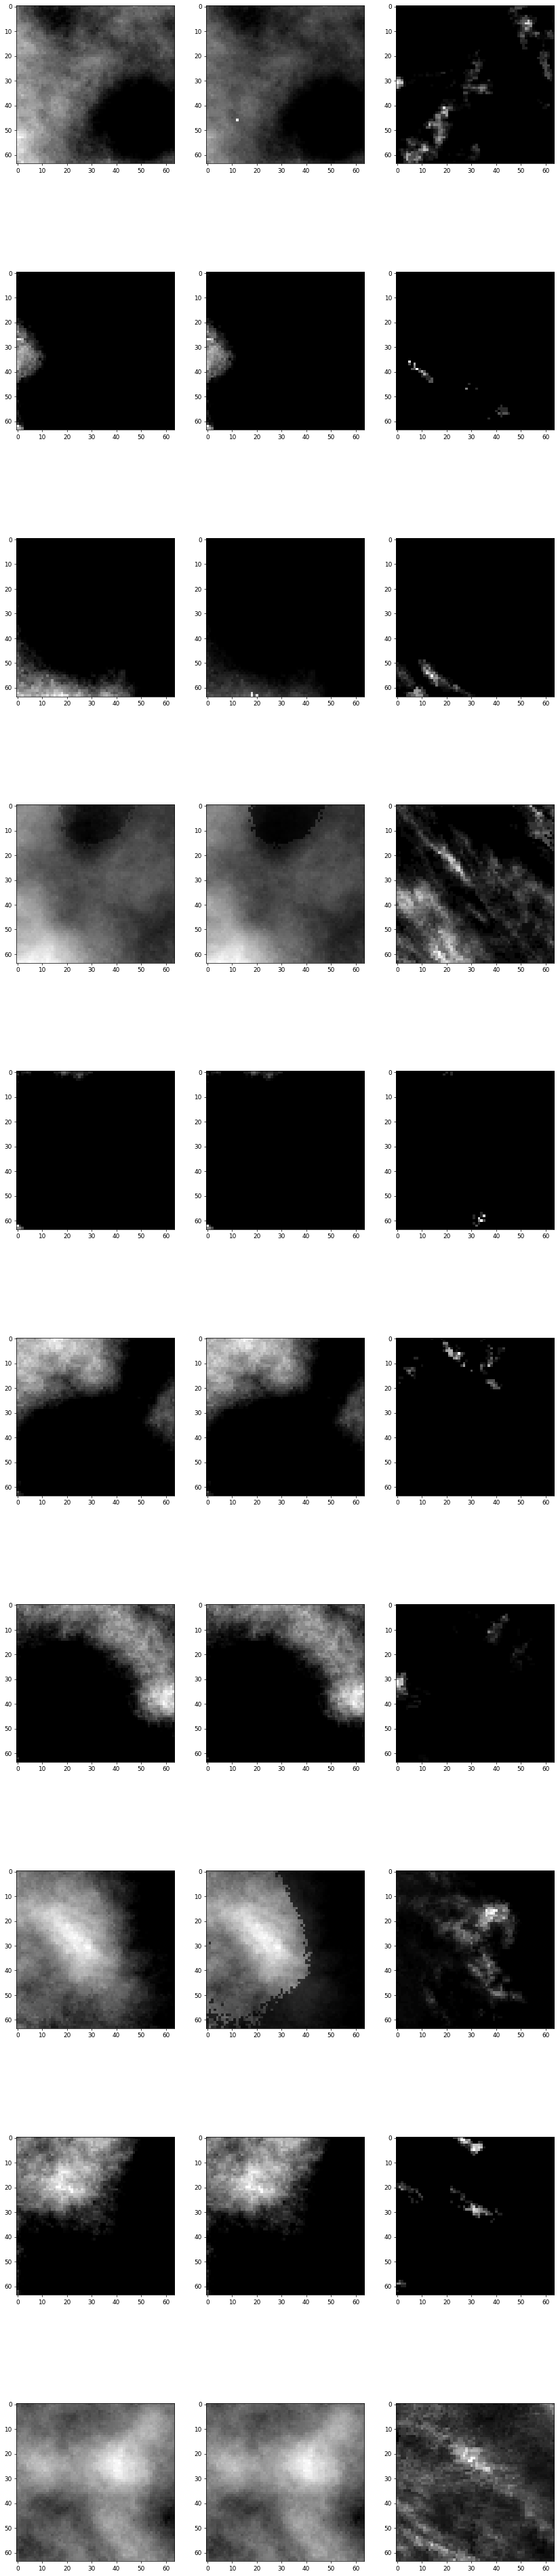

In [10]:
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")

In [13]:
for img in mean:
    print(np.max(img))

4.485512
0.9001749
4.103292
8.253675
0.68279505
1.8923439
2.423826
13.884605
2.6652586
15.680972
